# Fase C: Clustering de Productos

## Objetivos de la Notebook
1.  **Evaluación de Algoritmos:** Comparar K-Means con métricas de cohesión.
2.  **Determinación de K Óptimo:** Analizar el rango de 2 a 30 clusters. **Punto Crítico:** Resolver la discrepancia entre la visualización (que sugiere 3 grupos) y las métricas matemáticas (que sugieren 4).
3.  **Análisis de Granularidad:** Justificar por qué seleccionamos K=4 sobre K=6 a pesar de la búsqueda de detalle.
4.  **Perfilamiento de Negocio:** Traducir los clusters matemáticos a etiquetas de negocio ("Premium", "Mass Market") para la Fase D.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Configuración de visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Carga de datos procesados en Fase B
try:
    # Dataset numérico escalado (Para los algoritmos, index=Item_Identifier)
    df_model = pd.read_csv('../Data/Processed/product_level_modeling.csv', index_col='Item_Identifier')
    # Dataset con valores reales (Para la interpretación humana)
    df_interpret = pd.read_csv('../Data/Processed/product_level_interpretation.csv')
    print("✅ Datos cargados correctamente.")
except FileNotFoundError:
    print("❌ Error: Verifica la ruta de los archivos.")

✅ Datos cargados correctamente.


---
## 1. Determinación de K (Inercia vs Silhouette)

Ejecutaremos el algoritmo en un rango de **2 a 30**. Buscamos un K que tenga un Silhouette Score alto (buena separación) y una Inercia baja (buena compactación).

**Hipótesis de entrada:** Visualmente el PCA suele mostrar 3 grandes grupos (Categorías), pero buscamos matices de precio/ventas dentro de esos grupos.

🔄 Calculando métricas para K=2 a K=30...
K=2 | Silhouette=0.3156 | Inercia=14103.2
K=3 | Silhouette=0.2776 | Inercia=11347.1
K=4 | Silhouette=0.3109 | Inercia=9413.4
K=5 | Silhouette=0.2927 | Inercia=8044.4
K=6 | Silhouette=0.2927 | Inercia=7234.0
K=10 | Silhouette=0.2144 | Inercia=5923.2
K=15 | Silhouette=0.2116 | Inercia=4940.5


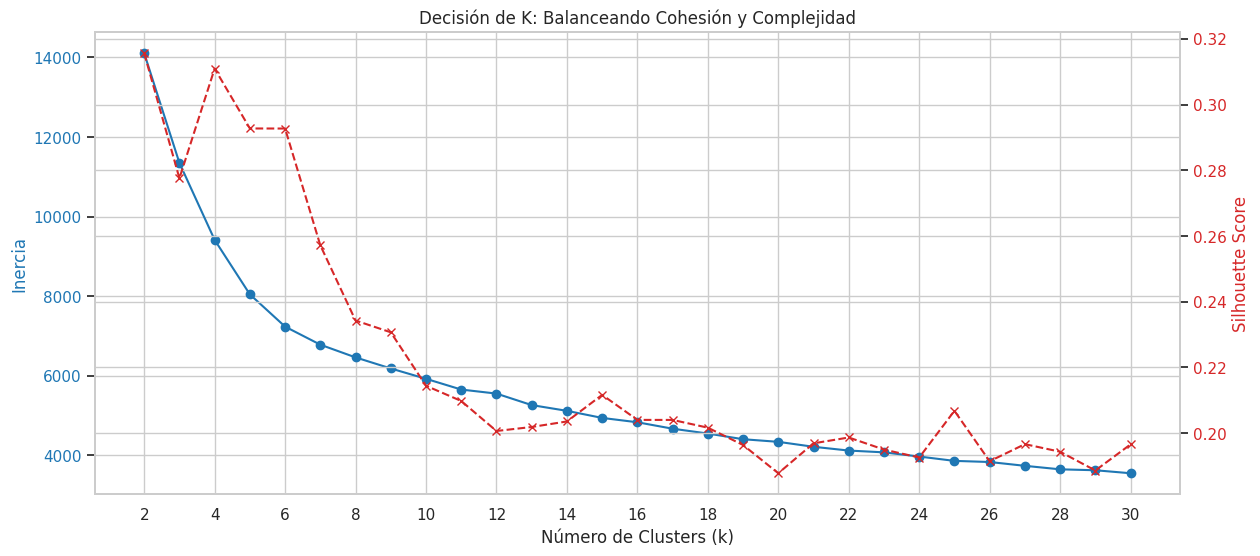

In [2]:
range_n_clusters = range(2, 31)
inertias = []
silhouette_scores = []

print("🔄 Calculando métricas para K=2 a K=30...")

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_model)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_model, cluster_labels))
    
    if k in [2, 3, 4, 5, 6, 10, 15]: # Prints clave
        print(f"K={k} | Silhouette={silhouette_scores[-1]:.4f} | Inercia={kmeans.inertia_:.1f}")

# Gráfica Dual
fig, ax1 = plt.subplots(figsize=(14, 6))
color = 'tab:blue'
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inercia', color=color)
ax1.plot(range_n_clusters, inertias, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(range_n_clusters, silhouette_scores, marker='x', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Decisión de K: Balanceando Cohesión y Complejidad')
plt.xticks(range(2, 31, 2))
plt.show()

### Análisis de Decisión: ¿Por qué K=4 y no K=6?

**Los Datos:**
* **K=4:** Silhouette **0.3109** (Pico local alto).
* **K=6:** Silhouette **0.2927** (Caída significativa).

**Interpretación:**
Aunque K=6 ofrece más granularidad, la caída en el Silhouette indica que los nuevos grupos creados no están bien definidos; se están solapando. En negocio, crear categorías difusas ("Ruido") es peligroso porque lleva a estrategias confusas.

**Decisión Final:** Nos quedamos con **K=4**. Es el punto óptimo donde maximizamos la separación matemática antes de empezar a degradar la calidad de los grupos por exceso de fragmentación.

---
## 2. Entrenamiento y la "Ilusión Visual" del PCA

Entrenaremos con K=4. Al graficar en PCA, veremos algo interesante: **Visualmente hay 3 bloques, pero el modelo detecta 4.**

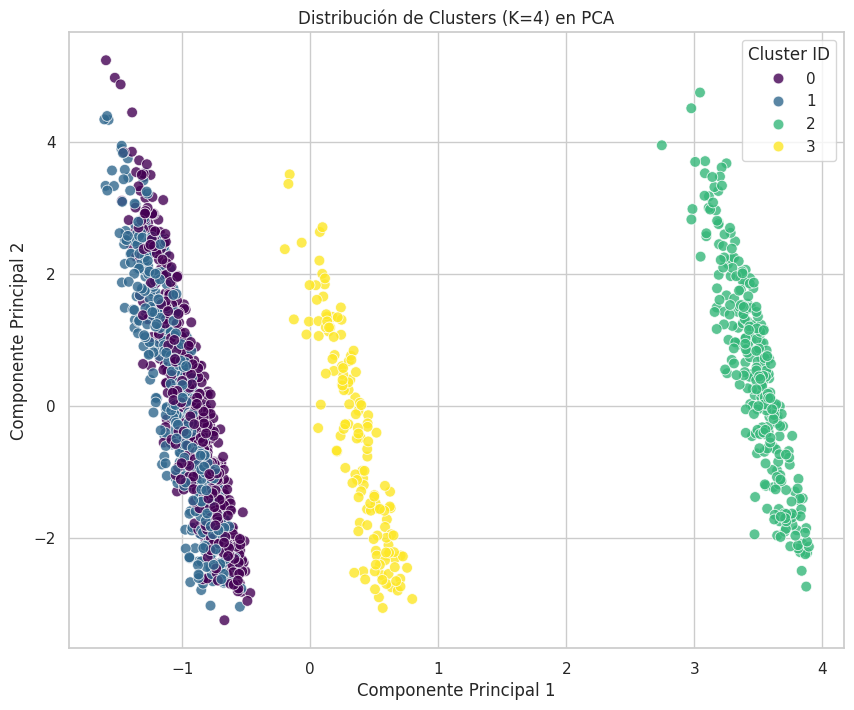

In [3]:
# Entrenar Modelo Final
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(df_model)
df_model['Cluster'] = clusters

# PCA para visualización
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_model.drop('Cluster', axis=1))
df_pca = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
df_pca['Cluster'] = clusters

# Visualización
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis', s=60, alpha=0.8)
plt.title('Distribución de Clusters (K=4) en PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster ID')
plt.show()

### Interpretación de la Discrepancia Visual

Si observamos la gráfica:
1.  **Bloque Derecho (Verde):** Muy separado. Seguramente `Non-Consumable`.
2.  **Bloque Central (Amarillo):** Muy separado. Seguramente `Drinks`.
3.  **Bloque Izquierdo (Morado/Azul):** Aquí está la clave. El PCA (2D) los muestra juntos, pero K-Means los separó.

Esto significa que **dentro de la categoría dominante (probablemente Comida)**, existen dos sub-comportamientos muy distintos (ej. Comida Barata vs Comida Cara) que están separados en las dimensiones que el PCA "aplanó". **Esta es la ganancia de usar K=4 sobre K=3.**

---
## 3. Perfilamiento de Negocio

Validaremos nuestra hipótesis revisando los promedios reales.

In [4]:
df_interpret['Cluster'] = clusters

# Perfilamiento Numérico
profile = df_interpret.groupby('Cluster').agg({
    'Total_Sales': 'mean',
    'Avg_MRP': 'mean',
    'Store_Count': 'mean',
    'Broad_Category': lambda x: x.mode()[0],
    'Item_Identifier': 'count'
}).sort_values('Broad_Category')

print("Perfil de los 4 Clusters:")
display(profile.style.background_gradient(cmap='Greens', subset=['Total_Sales', 'Avg_MRP']))

Perfil de los 4 Clusters:


,Total_Sales,Avg_MRP,Store_Count,Broad_Category,Item_Identifier
Cluster,,,,,
3,11005.995421,132.370867,5.510345,Drinks,145
0,12092.504109,142.266641,5.500000,Food,580
1,12162.137719,141.100732,5.445269,Food,539
2,11614.276138,142.623000,5.420339,Non-Consumable,295


In [5]:
# Etiquetado Automático basado en reglas (Ajustar lógica según el output anterior)
def label_cluster(row):
    # Ejemplo de lógica basada en tus resultados previos:
    # Cluster 0 y 1 son Food. Uno tiene más ventas/MRP que el otro?
    # Cluster 2 es Non-Consumable
    # Cluster 3 es Drinks
    
    cat = row['Broad_Category']
    if cat == 'Non-Consumable':
        return 'Non-Edible Goods'
    elif cat == 'Drinks':
        return 'Drinks'
    elif cat == 'Food':
        # Diferenciación dentro del bloque "Food" (La separación oculta en PCA)
        if row['Avg_MRP'] > 140: # Umbral hipotético, revisar tabla
            return 'Food: Mass Market / High Rev'
        else:
            return 'Food: Low Viz / Economy'
    return 'Other'

# Aplicar etiquetas
df_interpret['Cluster_Label'] = df_interpret.apply(label_cluster, axis=1)

print("Validación de Etiquetas:")
print(df_interpret[['Item_Identifier', 'Broad_Category', 'Avg_MRP', 'Cluster', 'Cluster_Label']].sample(5))

Validación de Etiquetas:
     Item_Identifier Broad_Category     Avg_MRP  Cluster  \
942            FDT32           Food  188.371400        1   
643            FDM44           Food  103.970429        0   
1115           FDW59           Food   84.923267        0   
80             DRI13         Drinks  217.400800        3   
640            FDM38           Food   53.948200        1   

                     Cluster_Label  
942   Food: Mass Market / High Rev  
643        Food: Low Viz / Economy  
1115       Food: Low Viz / Economy  
80                          Drinks  
640        Food: Low Viz / Economy  


---
## 4. Exportación para Fase D

Este archivo será crucial para entender el "ADN" de cada tienda en la siguiente fase.

In [6]:
output_path = '../Data/Processed/product_level_with_clusters.csv'
df_interpret.to_csv(output_path, index=False)
print(f"✅ Archivo exportado: {output_path}")

✅ Archivo exportado: ../Data/Processed/product_level_with_clusters.csv
